# Import

In [1]:
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from torchsummary import summary

from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
import kaggle
import zipfile
import shutil
import gc
import os
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(17)
torch.cuda.manual_seed(17)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cuda


# Data

In [3]:
def download_and_extract_data():
    """
    Downloads the data from Kaggle and extracts it.

    :return: The path to the extracted data.
    :rtype: pathlib.Path
    :raises: None
    """
    path = Path('kmader/food41')
    data_path = Path('data')
    kaggle.api.dataset_download_cli(str(path))
    if not data_path.exists():
        os.mkdir(data_path)
        zipfile.ZipFile('food41.zip').extractall(data_path)
    return data_path

def setup_folder():
    """
    Downloads and extracts the data, and sets up the folder structure
    for training and validation/testing.

    :return: The path to the extracted data.
    :rtype: pathlib.Path
    :raises: None
    """
    data_path = download_and_extract_data()
    if os.path.exists('data/train'):
        return data_path
    
    with open(data_path/'meta/meta/train.json', 'r') as fp:
        train_dict = json.load(fp)
    with open(data_path/'meta/meta/test.json', 'r') as fp:
        test_dict = json.load(fp)

    new_folders = ['train', 'test']
    for folder in new_folders:
        if not os.path.exists(data_path/folder):
            os.mkdir(data_path/folder)
        if folder == 'train':
            if not os.path.exists(data_path/'valid'):
                os.mkdir(data_path/'valid')
            for key, value in train_dict.items():
                train_value, valid_value = train_test_split(value, train_size=0.75)
                train_set, valid_set = set(train_value), set(valid_value)
                if not os.path.exists(data_path/folder/key):
                    os.mkdir(data_path/folder/key)
                if not os.path.exists(data_path/'valid'/key):
                    os.mkdir(data_path/'valid'/key)
                for image in os.listdir(data_path/'images'/key):
                    image_path = key + '/' + image
                    image_id = image_path.split('.')[0]
                    if image_id in train_set:
                        shutil.move(data_path/'images'/image_path, data_path/folder/image_path)
                    if image_id in valid_set:
                        shutil.copy(data_path/'images'/image_path, data_path/'valid'/image_path)
        else:
            for key, value in test_dict.items():
                test_set = set(value)
                if not os.path.exists(data_path/folder/key):
                    os.mkdir(data_path/folder/key)
                for image in os.listdir(data_path/'images'/key):
                    image_path = key + '/' + image
                    image_id = image_path.split('.')[0]
                    if image_id in test_set:
                        shutil.move(data_path/'images'/image_path, data_path/folder/image_path)
    shutil.rmtree(data_path/'images')
    return data_path

def get_data_loaders(batch_size=64):
    """
    Returns the data loaders for training, validation, and testing.

    :param batch_size: The batch size for the data loaders.
    :type batch_size: int
    :return: A tuple containing three data loaders.
             The first data loader is for training data,
             the second data loader is for validation data,
             and the third data loader is for testing data. 
             Each data loader is an instance of the `torch.utils.data.DataLoader` class.
    :rtype: tuple
    :raises: None
    """
    data_path = setup_folder()
    train_transforms, valid_n_test_transforms = get_data_transforms()

    train_data = datasets.ImageFolder(str(data_path/'train'), transform=train_transforms)
    valid_data = datasets.ImageFolder(str(data_path/'valid'), transform=valid_n_test_transforms)
    test_data = datasets.ImageFolder(str(data_path/'test'), transform=valid_n_test_transforms)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader, test_loader, test_data

def get_metadata(dataset):
    """
    Returns the metadata for the dataset.

    :param dataset: The dataset.
    :type dataset: torch.utils.data.Dataset
    :return: A tuple containing three items.
            The first item is a list of class names.
            The second item is a dictionary mapping class names to indices.
            The third item is a dictionary mapping indices to class names.
    :rtype: tuple
    :raises: None
    """
    classess, class_to_idx = dataset.classes, dataset.class_to_idx
    idx_to_class = {value: key for key, value in class_to_idx.items()}
    return classess, class_to_idx, idx_to_class

def get_data_transforms():
    """
    Returns the data transforms for training and validation/testing.

    :return: A tuple containing two transforms.
             The first transform is for training data and
             the second transform is for validation/testing data.
    :rtype: tuple
    :raises: None
    """
    train_transforms = T.Compose([T.RandomResizedCrop(224),
                                      T.RandomRotation(35),
                                      T.RandomVerticalFlip(0.27),
                                      T.RandomHorizontalFlip(0.27),
                                      T.ToTensor(),
                                      T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    valid_n_test_transforms = T.Compose([T.Resize((224,224)),
                                       T.ToTensor(),
                                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    return train_transforms, valid_n_test_transforms

In [4]:
train_loader, valid_loader, test_loader, test_data = get_data_loaders(32)
classes, class_to_idx, idx_to_class = get_metadata(test_data)
print('classes: ', classes)
print('class_to_idx: ', class_to_idx)
print('idx_to_class: ', idx_to_class)

food41.zip: Skipping, found more recently modified local copy (use --force to force download)
classes:  ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cr

# Visualization

In [5]:
def imshow(image, ax=None, title=None):
    """
    imshow for IMAGENET-style transformed images in
    torch.Tensor format.

    :param image: The image to be plotted.
    :type image: torch.Tensor
    :param ax: The axis to plot the image on.
    :type ax: matplotlib.axes.Axes
    :param title: The title of the plot.
    :type title: str
    :return: The axis with the plotted image.
    :rtype: matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0))
    
    # Undo preprocessing
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = (std * image + mean)
    
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    
    return ax

def image_grid(images, labels, idx_to_class, rows=2, cols=4, figsize=(20, 10)):
    """
    Plots a grid of images and their labels.

    :param images: The images to be plotted.
    :type images: torch.Tensor
    :param labels: The labels of the images.
    :type labels: torch.Tensor
    :param class_to_idx: A dictionary mapping class names to indices.
    :type class_to_idx: dict
    :param idx_to_class: A dictionary mapping indices to class names.
    :type idx_to_class: dict
    :param rows: The number of rows in the grid.
    :type rows: int
    :param cols: The number of columns in the grid.
    :type cols: int
    :param figsize: The size of the figure.
    :type figsize: tuple
    :return: None
    :rtype: None
    """
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax = imshow(images[i], ax=ax, title=idx_to_class[labels[i].item()])
    plt.tight_layout()
    plt.show()

In [6]:
x, y = next(iter(train_loader))

<Axes: title={'center': 'greek_salad'}>

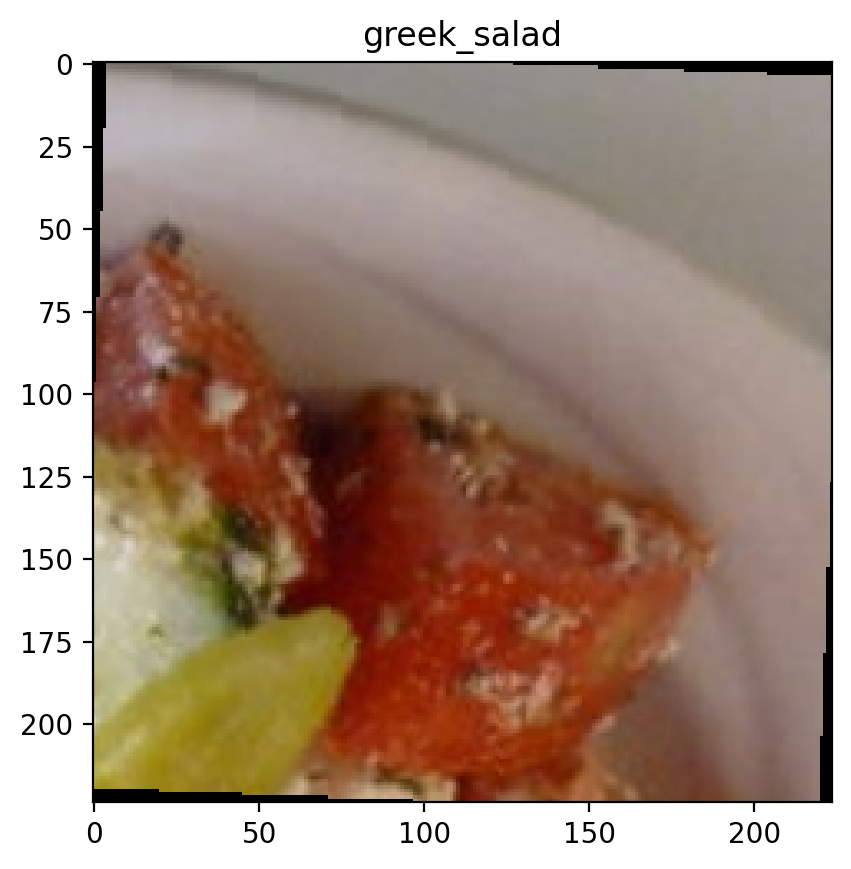

In [7]:
imshow(x[0], title=f'{idx_to_class.get(int(y[0]), "Unknown")}')

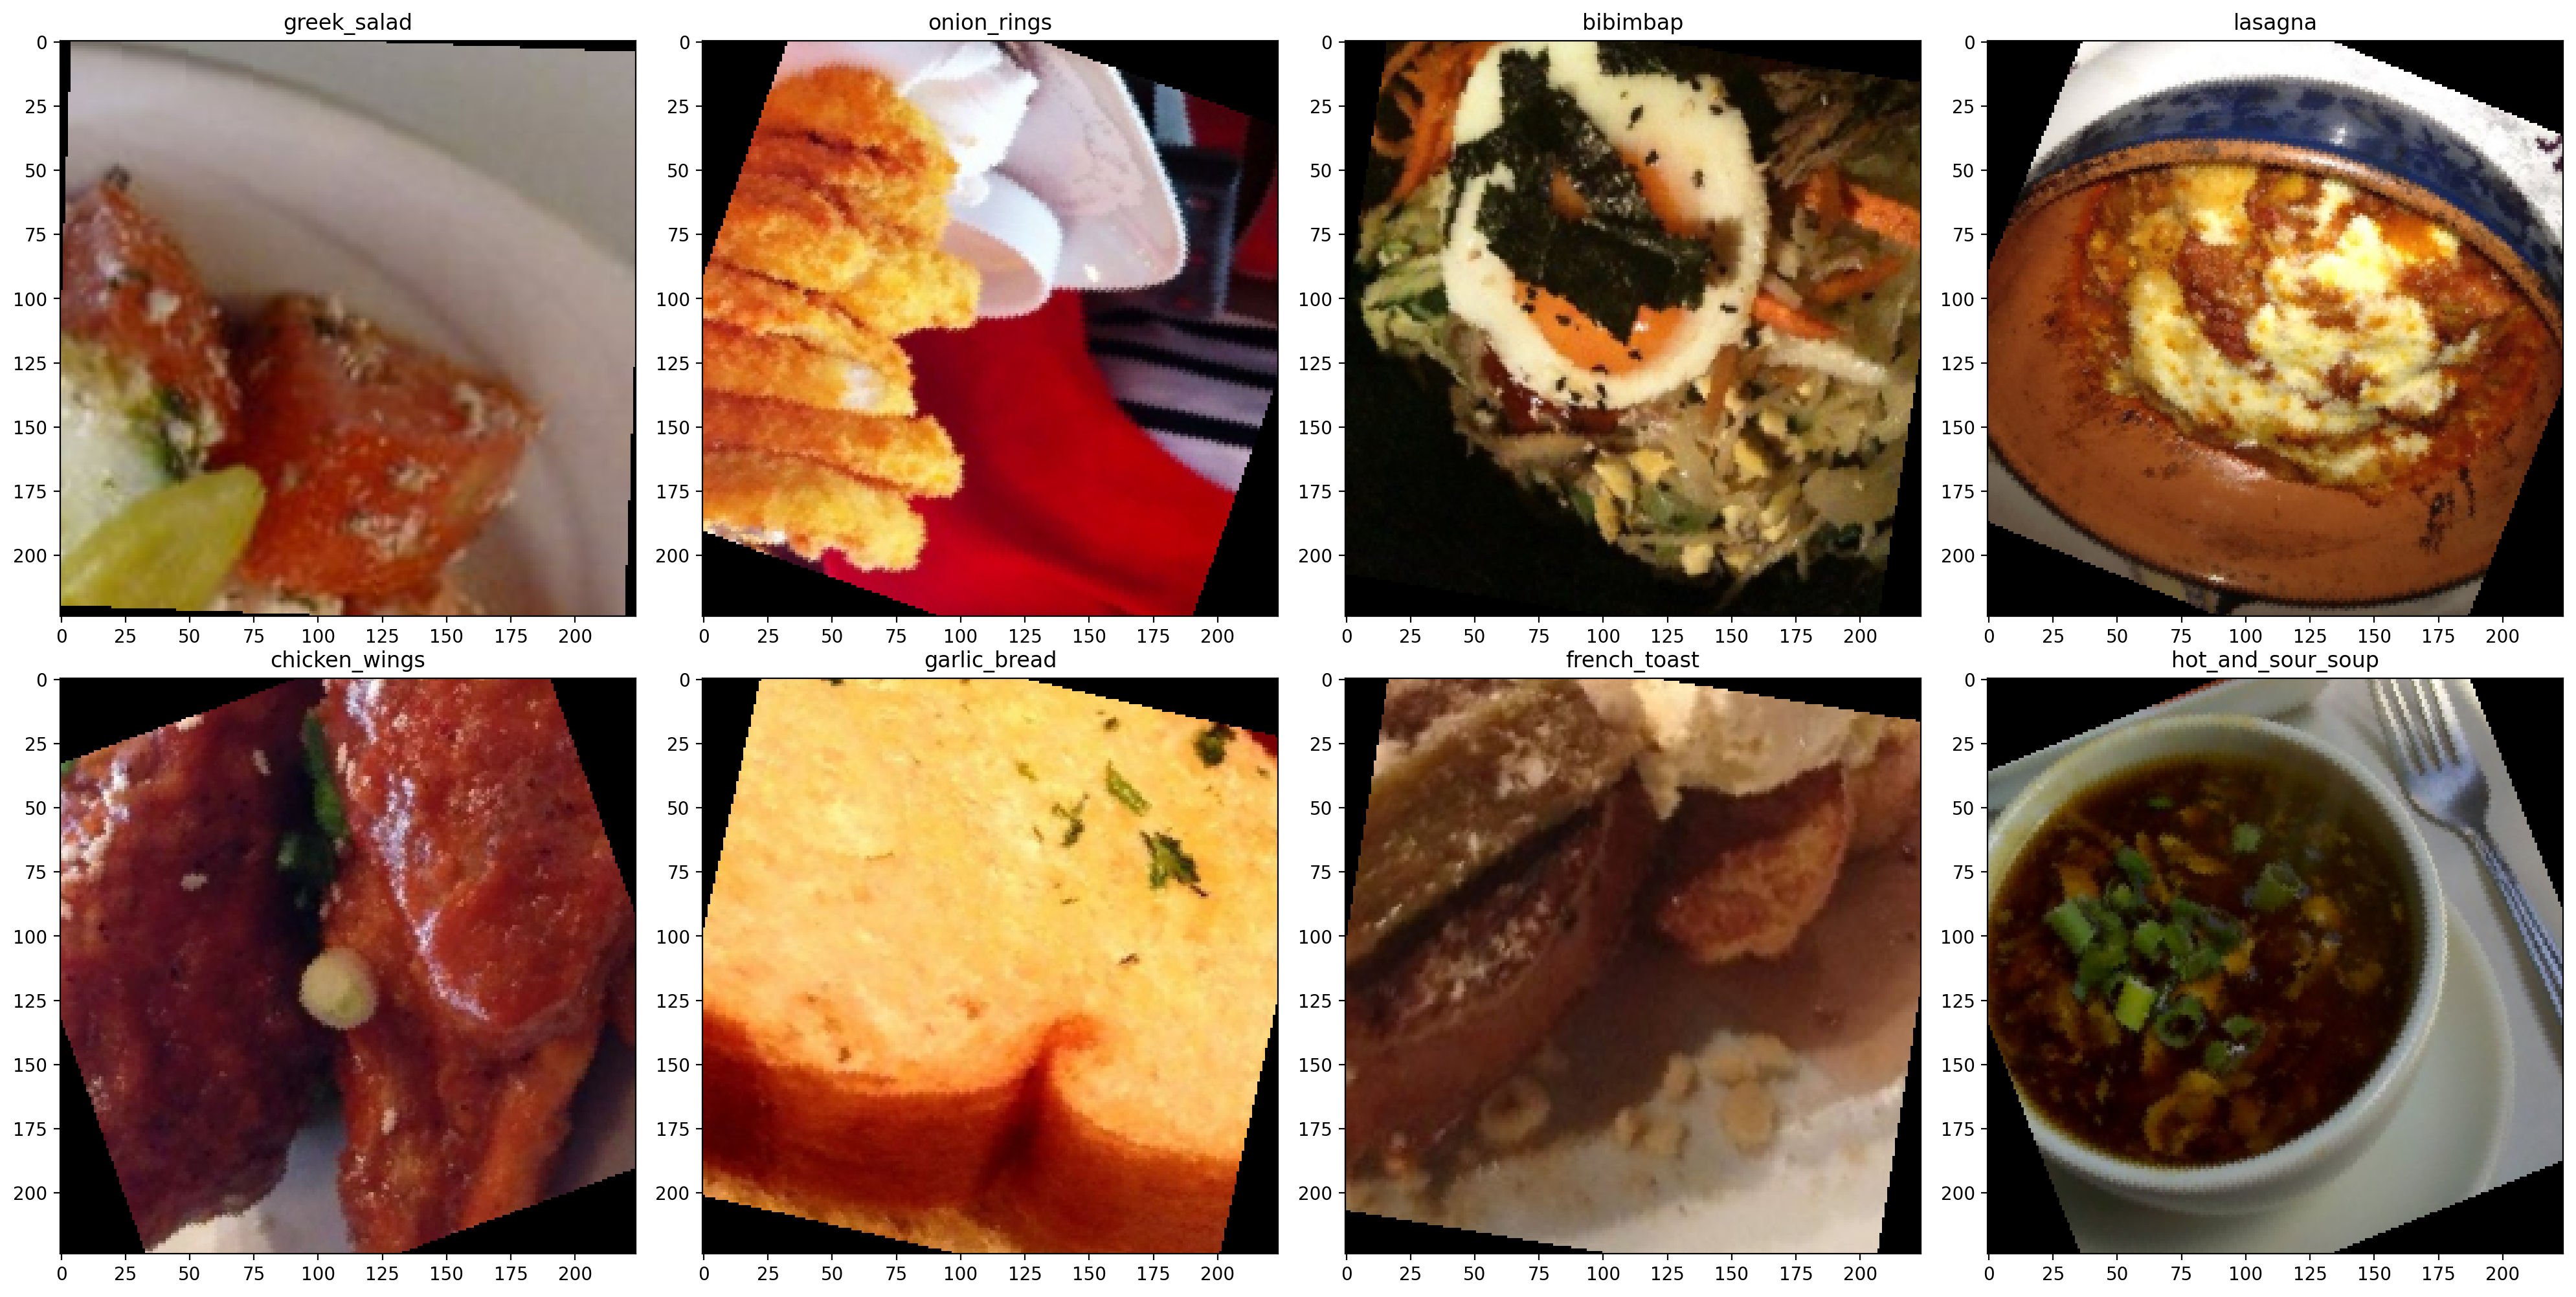

In [8]:
image_grid(x, y, idx_to_class)

# Setup for finetuning

## Set up model

In [9]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

Naive random pick from [https://www.kaggle.com/code/jhoward/which-image-models-are-best](https://www.kaggle.com/code/jhoward/which-image-models-are-best)

In [10]:
model = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=101)
model.to(device)

summary(model, (3, 224, 224))

/root/miniconda3/envs/cb0494/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 56, 56]           9,408
         LayerNorm-2          [-1, 56, 56, 192]             384
        PatchEmbed-3          [-1, 56, 56, 192]               0
          Identity-4          [-1, 56, 56, 192]               0
         LayerNorm-5          [-1, 56, 56, 192]             384
            Linear-6              [-1, 49, 576]         111,168
           Softmax-7            [-1, 6, 49, 49]               0
           Dropout-8            [-1, 6, 49, 49]               0
            Linear-9              [-1, 49, 192]          37,056
          Dropout-10              [-1, 49, 192]               0
  WindowAttention-11              [-1, 49, 192]               0
         Identity-12          [-1, 56, 56, 192]               0
        LayerNorm-13            [-1, 3136, 192]             384
           Linear-14            [-1, 31

In [11]:
sample_output = model(x[0].unsqueeze(0).to(device))
sample_output, y[0] # sample_output is purely random at the moment

(tensor([[-0.0842,  0.2674,  0.1003, -0.2322, -0.4749, -0.3006, -0.6074, -0.0545,
           0.6406,  0.0120,  0.2084,  0.5483,  0.1860,  0.2231,  0.2529, -0.0909,
          -0.0559,  0.1120, -0.1937, -0.1228, -0.3978, -0.0298,  0.3698, -0.3967,
          -0.1889, -0.6635,  0.0026,  0.0963, -0.0859, -0.2058, -0.2750, -0.0374,
           0.6600, -0.2126, -0.1250,  0.4237, -0.1057,  0.2732, -0.0179, -0.0560,
          -0.4034, -0.3667, -0.0235, -0.2198, -0.1305,  0.4693,  0.2159,  0.1323,
           0.1450,  0.5143, -0.0488, -0.3584,  0.1005, -0.2161,  0.3869,  0.0649,
           0.3773,  0.1671, -0.2974,  0.5594, -0.2633, -0.0888, -0.2529,  0.6128,
           0.3241,  0.4597, -0.0755, -0.3110,  0.1357, -0.1531,  0.3554, -0.1434,
           0.0271,  0.1641,  0.1065, -0.0453, -0.0931,  0.2573,  0.0833, -0.5938,
           0.0266, -0.5856,  0.3015,  0.2328,  0.2262, -0.4443, -0.2314,  0.2724,
           0.2472, -0.2466, -0.2077, -0.2408, -0.0415,  0.4822, -0.4788, -0.3731,
           0.104

In [12]:
sample_output.argmax()

tensor(32, device='cuda:0')

## Set up optimizer, metric, training, and testing functions

In [13]:
def cuda_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
accuracy_fn = Accuracy(task='multiclass', num_classes=101).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00001) # From the paper fine-tuning section
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, total_steps=30) # Randomly chosen

In [15]:
def train_step(model: torch.nn.Module,
               data_loader: DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler.LRScheduler,
               accuracy_fn=accuracy_fn,
               device=device):
    train_loss, train_acc = 0, 0
    model.train()
    # Model is expected to be in GPU already
    for _, (images, labels) in tqdm(enumerate(data_loader),
                                        total=len(data_loader),
                                        desc='Training model:'):
        images, labels= images.to(device), labels.to(device)

        # 1. Forward pass
        preds = model(images)

        # 2. Calculate loss
        loss = loss_fn(preds, labels)
        train_loss += loss
        train_acc += accuracy_fn(preds.argmax(dim=1), labels)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Garbage collection on GPU RAM
        if device == torch.device('cuda'):
            cuda_collect()
    scheduler.step()
    # Exponential learning rate scheduler reduces learning rate too fast
    # A better option is torch.optim.lr_scheduler.OneCycleLR from the paper
    # of https://arxiv.org/pdf/1708.07120.pdf on MNIST dataset
    # I changed from exponential learning rate to onecycle learning scheduler
    # as performance became slow after 70 epochs.

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")
    return train_loss.cpu(), train_acc.cpu()

def test_step(model: torch.nn.Module,
               data_loader: DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn=accuracy_fn,
               device=device):
    test_loss, test_acc = 0, 0
    model.eval()
    # Turn on inference context manager
    with torch.inference_mode():
        for images, labels in tqdm(data_loader,
                                    total=len(data_loader),
                                    desc='Making predictions:'):

            images, labels= images.to(device), labels.to(device)

            # 1. Forward pass
            preds = model(images)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(preds, labels)
            test_acc += accuracy_fn(preds.argmax(dim=1), labels)

            gc.collect()
            torch.cuda.empty_cache()

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")
    return test_loss.cpu(), test_acc.cpu()

In [16]:
epochs = 1
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [17]:
tolerance = 0
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, scheduler)
    valid_loss, valid_acc = test_step(model, valid_loader, criterion)
    train_losses.append(train_loss), train_accuracies.append(train_acc)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_acc)
    if len(valid_losses) > 1 and float(valid_losses[-2] - valid_losses[-1]) < 1e-4:
        tolerance += 1
        if tolerance > 2:
            break

  0%|          | 0/1 [00:00<?, ?it/s]

Training model::   0%|          | 0/2218 [00:00<?, ?it/s]

Train loss: 1.17716 | Train accuracy: 0.71


Making predictions::   0%|          | 0/1038 [00:00<?, ?it/s]

Test loss: 0.44665 | Test accuracy: 0.87


In [25]:
train_losses = [x.detach() for x in train_losses]
valid_losses = [x.detach() for x in valid_losses]
train_accuracies = [x.cpu() for x in train_accuracies]
valid_accuracies = [x.cpu() for x in valid_accuracies]

In [26]:
train_losses, valid_losses, train_accuracies, valid_accuracies

([tensor(1.1772)], [tensor(0.4467)], [tensor(0.7124)], [tensor(0.8744)])

In [27]:
def plot_training(train_losses, valid_losses, train_accuracies, valid_accuracies):
    num_epochs = len(train_losses)
    epochs = range(1, num_epochs + 1)

    # Plot subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss subplot
    ax1.plot(epochs, train_losses, label='Training Loss')
    ax1.plot(epochs, valid_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracy subplot
    ax2.plot(epochs, train_accuracies, label='Training Accuracy')
    ax2.plot(epochs, valid_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    # Show the plot
    plt.show()

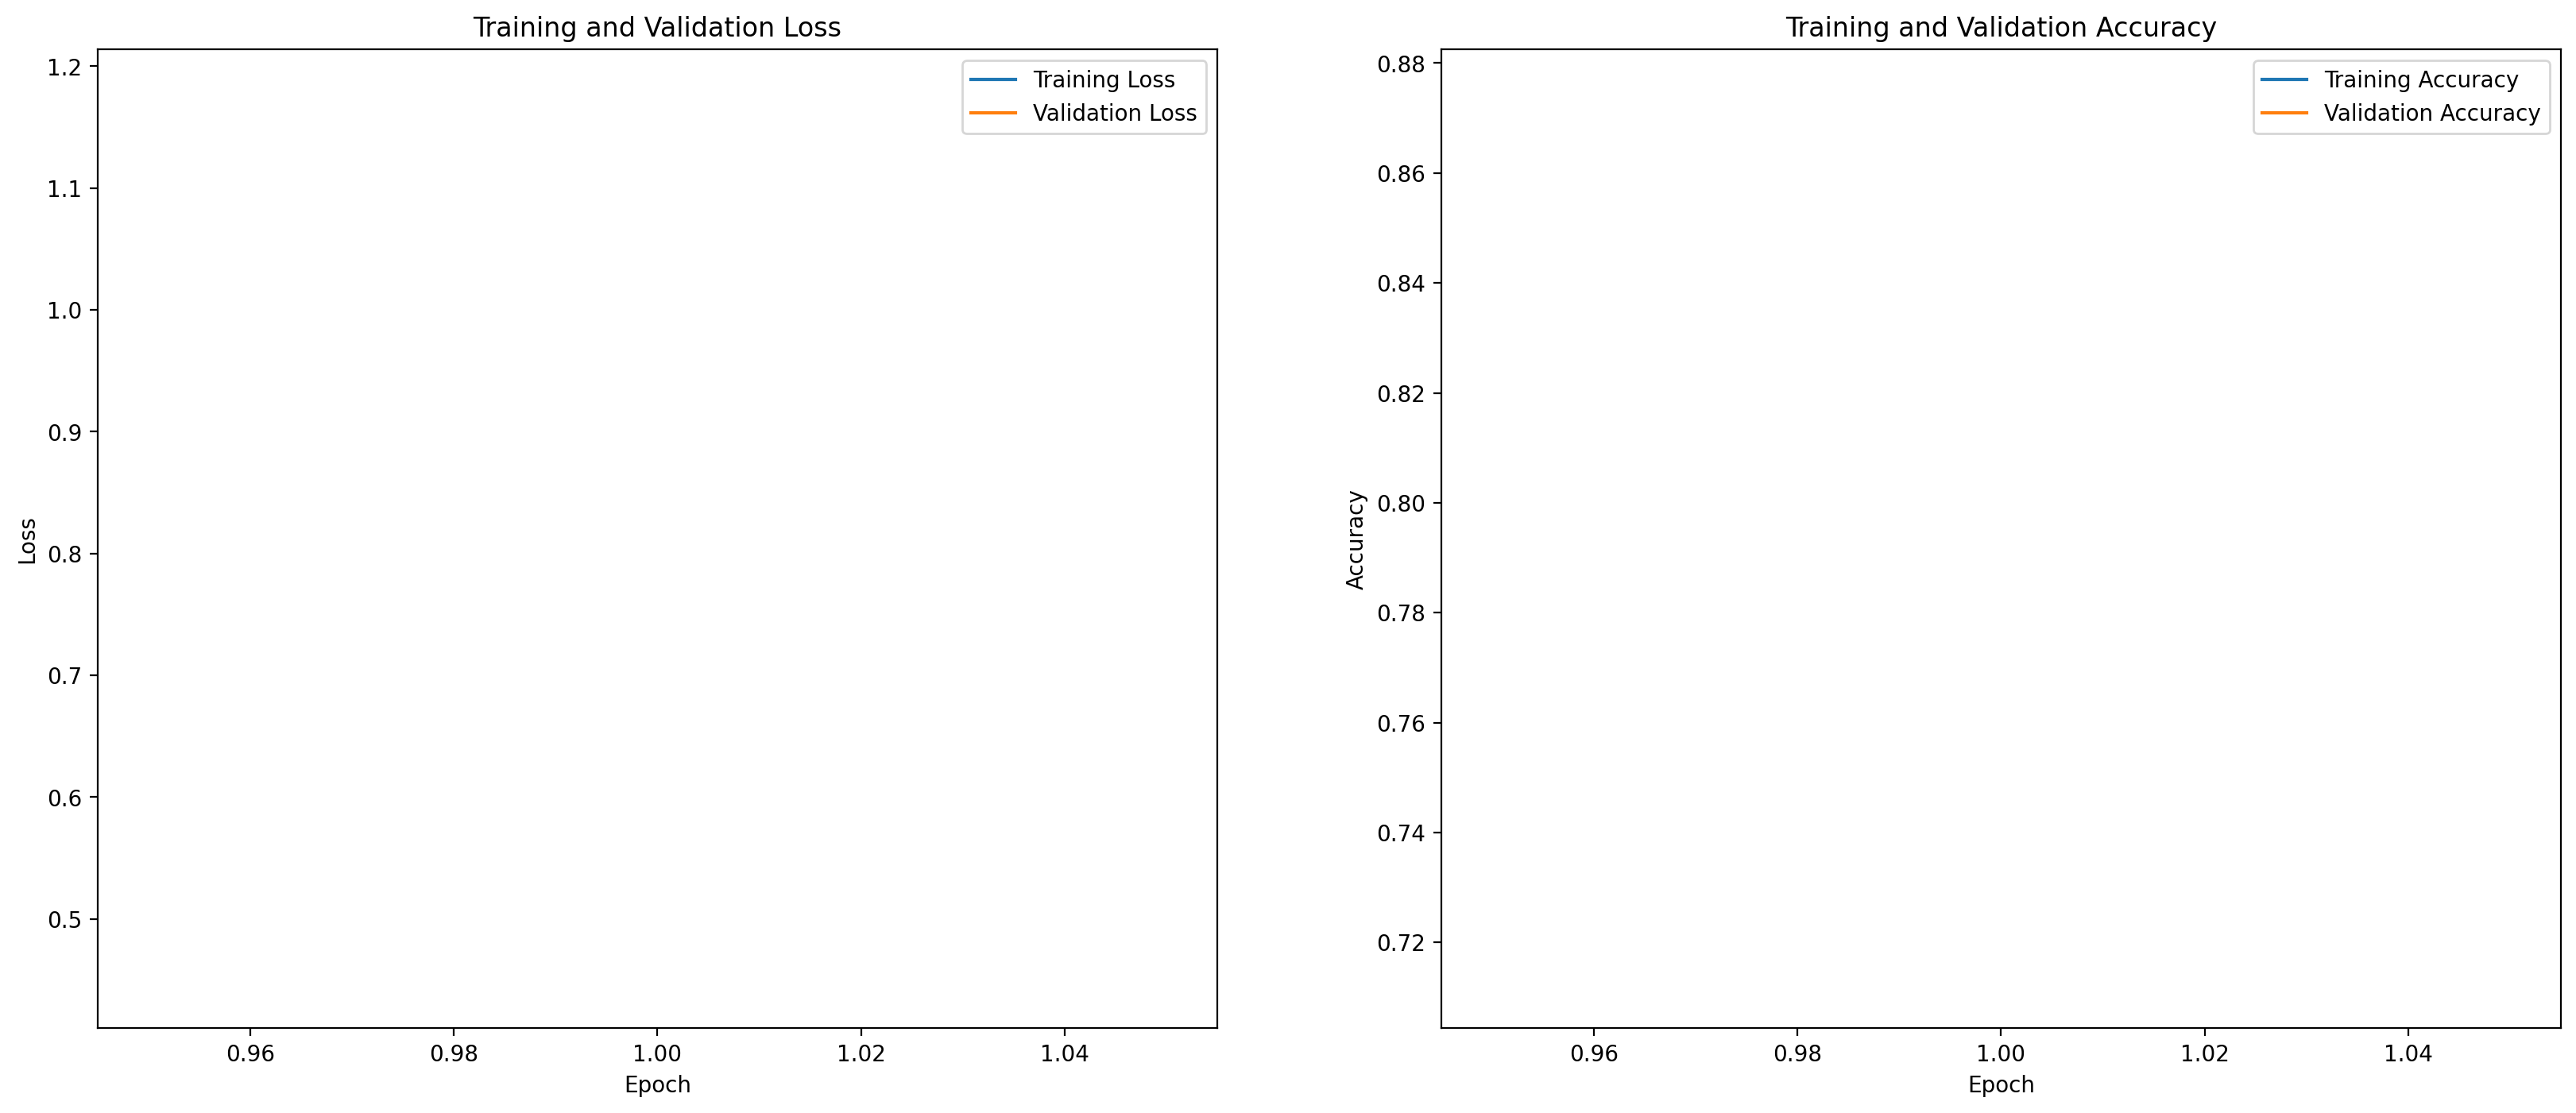

In [28]:
plot_training(train_losses, valid_losses, train_accuracies, valid_accuracies)

A better plot should appear if the number of epochs is larger than 1. However, since each epoch is gonna take 30 minutes, and I want to do so for 30 epochs, it's gonna be 15 hours. I don't have that much time to wait. This is also another reason to use a script after experiment with a notebook: with appliccation such as `tmux`, I can run the program while I sleep and wake up to check the result.

New let's try saving and loading the model.

## Saving and loading model

In [29]:
torch.save(model.state_dict(), 'models/model.pth')

In [30]:
inference_model = timm.create_model('swin_large_patch4_window7_224', pretrained=False, num_classes=101)
inference_model.load_state_dict(torch.load('models/model.pth'))
inference_model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
            (d

In [31]:
valid_loss, valid_acc = test_step(inference_model, valid_loader, criterion)
print(f"Test loss: {valid_loss:.5f} | Test accuracy: {valid_acc:.2f}")

Making predictions::   0%|          | 0/1038 [00:00<?, ?it/s]

Test loss: 0.44665 | Test accuracy: 0.87
Test loss: 0.44665 | Test accuracy: 0.87


That seems correct. Now let's try creating a Gradio demo for the model.

In [32]:
import gradio as gr

In [33]:
def gr_predict(img):
    """Predict on Gradio interface
    
    Args:
        img (np.ndarray): Image array
        
    Returns:
        int: Predicted class
    """
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
    pred = inference_model(img)
    return pred.argmax(dim=1).cpu().numpy()[0]


In [37]:
interface_options = {
    "title": "Food Image Classifier (Food-101)",
    "description": "A food image classifier trained on the Food-101 dataset. (Dataset from : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)",
    "layout": "horizontal",
    "theme": "default",
}

demo = gr.Interface(fn=gr_predict,
                      inputs=gr.inputs.Image(shape=(224, 224)),
                      outputs=gr.outputs.Label(num_top_classes=5),
                      **interface_options)

launch_options = {
    "enable_queue": True,
    "share": False 
}

demo.launch(**launch_options)

/root/miniconda3/envs/cb0494/lib/python3.11/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/root/miniconda3/envs/cb0494/lib/python3.11/site-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/root/miniconda3/envs/cb0494/lib/python3.11/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/root/miniconda3/envs/cb0494/lib/python3.11/site-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)
/tmp/ipykernel_25567/1382428025.py:8: UserWarning: `layout` parameter is deprecated, and it has no 

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
